In [8]:
%cd turnus
%load_ext autoreload
%autoreload 2

[Errno 2] No such file or directory: 'turnus'
/home/dmatis/s/ssd/rl-optimization/turnus


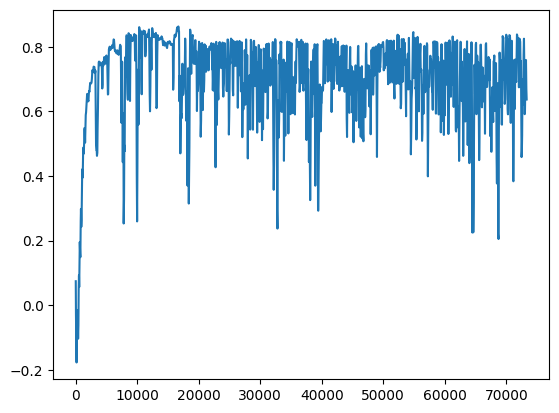

KeyboardInterrupt: 

In [1]:
from IPython.display import clear_output
import time
import pandas as pd
import matplotlib.pyplot as plt

while True:
    clear_output(wait=True)
    df = pd.read_csv('results/data/ppo_2.txt')
    plt.plot(df['episode'], df['avg_score'])
    plt.show()
    time.sleep(5)

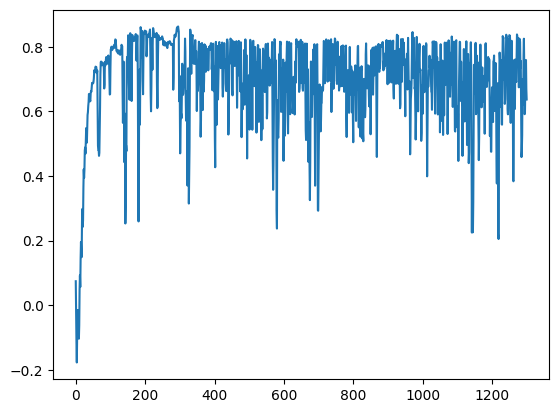

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('results/data/ppo_2.txt')
plt.plot(df['iteration'], df['avg_score'])

In [3]:
import torch
from env import Env
import graph_utils
from model import GCN
from utils import reward_to_obj

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)
graph = graph_utils.load_graph('data/1')

env = Env(graph, device)

net = GCN(env.state_space(), env.action_space()).to(device)
state_dict = torch.load('results/models/ppo_2_295_ppo.pt')
net.load_state_dict(state_dict)
net.eval()

observation, mask = env.reset()
terminal = False

r_sum = 0
while not terminal:
    logit, value = net(observation)
    logit = torch.where(mask, logit, torch.tensor(-1e+8, device=device))
    action = logit.argmax()
    observation, mask, reward, terminal, _ = env.step(action.item())
    r_sum += reward

r_sum, reward_to_obj(r_sum, 4, env.MAX_VEHICLES)

device:  cuda


(0.8723404255319149, 7.0)

In [11]:
def get_tours_by_vehicles(graph, env):
    vehicles = {}
    for i in range(graph.num_nodes):
        node = graph.x[i]
        vehicle = (node[env.visited_flag_index] * env.MAX_VEHICLES).item()

        if vehicle != int(vehicle):
            raise ValueError("Vehicle ID is not an integer")

        vehicle = int(vehicle)

        if str(vehicle) not in vehicles:
            vehicles[str(vehicle)] = []

        vehicles[str(vehicle)].append(i)

    return vehicles

get_tours_by_vehicles(observation.cpu(), env)

{'6': [0, 4, 7, 13, 17, 20, 29, 36],
 '4': [1, 6, 11, 16, 24, 25, 31, 34, 39],
 '3': [2, 12, 18, 26, 30, 38, 43, 45],
 '2': [3, 10, 19, 21, 28, 35, 37, 42, 44, 47],
 '1': [5, 9, 15, 33, 41, 46, 48, 49],
 '5': [8, 22, 23, 27, 32, 40],
 '0': [14, 50]}

In [37]:
from torch_geometric.data import Data

def get_result_subgraph(graph, env):
    vehicle_tours = get_tours_by_vehicles(graph, env)

    edges = []
    for vehicle, node_ids in vehicle_tours.items():
        for i in range(len(node_ids) - 1):
            edges.append([node_ids[i], node_ids[i+1]])

    edges = torch.tensor(edges)

    return Data(x=graph.x, edge_index=edges.t().contiguous())

get_result_subgraph(observation.cpu(), env)

Data(x=[51, 6], edge_index=[2, 44])

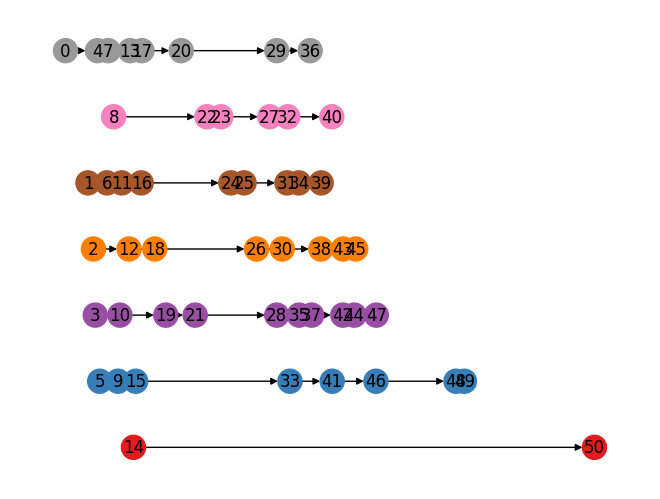

In [42]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def draw_graph_by_vehicles(graph, env):
    node_labels = graph.x[:, env.visited_flag_index].numpy()
    positions = {}

    for i in range(graph.num_nodes):
        node = graph.x[i]
        positions[i] = [node[2], node[env.visited_flag_index]]

    g = to_networkx(graph)
    nx.draw(g, pos=positions, cmap=plt.get_cmap('Set1'), node_color=node_labels, with_labels=True)

draw_graph_by_vehicles(get_result_subgraph(observation.cpu(), env), env)

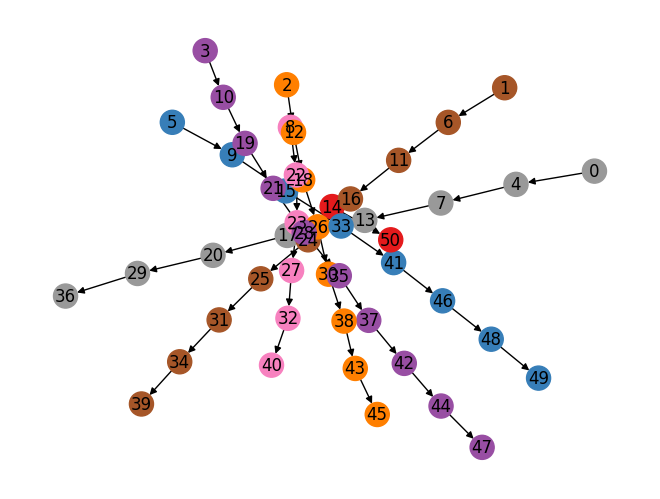

In [51]:
def draw_graph(graph, env):
    node_labels = graph.x[:, env.visited_flag_index].numpy()
    positions = {}


    # for i in range(graph.num_nodes):
    #     node = graph.x[i]
    #     positions[i] = [node[2], node[env.visited_flag_index]]

    g = to_networkx(graph)
    pos = nx.circular_layout(to_networkx(observation.cpu()))
    nx.draw(g, pos=pos, cmap=plt.get_cmap('Set1'), node_color=node_labels, with_labels=True)
    
draw_graph(get_result_subgraph(observation.cpu(), env), env)